In [1]:
import numpy as np

# Save fonts into pdf
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42


import matplotlib.pyplot as plt
import tqdm.notebook
# import scipy.integrate

In [2]:
matplotlib.rcParams.update({'font.size': 8, 'axes.linewidth': 0.5, 'xtick.major.width': 0.5, 'xtick.minor.width': 0.5, 
                            'ytick.major.width': 0.5,'ytick.minor.width': 0.5, 'xtick.major.pad':2,'ytick.major.pad':2})
matplotlib.rcParams.update({'font.family':'sans-serif','font.sans-serif':['Arial'], 'mathtext.default':'sf','mathtext.fontset':'custom'})

matplotlib.rcParams.update({'savefig.transparent':True})

In [3]:
# Compute a periodic convolution
# Edited from: https://stackoverflow.com/questions/35474078/python-1d-array-circular-convolution
def conv_circ( signal, ker ):
    '''
        signal: real 1D array
        ker: real 1D array
        signal and ker must have same shape
    '''
    if len(ker) < len(signal):
        ker = np.pad(ker, (0, len(signal)-len(ker)))
    return np.real(np.fft.ifft( np.fft.fft(signal)*np.fft.fft(ker) ))

# Generating PF basis 
def generatePFratesBasis(N_PFs = 120, a=5, theta=9):
    # Number of PFs, peak spike rate (Hz), threshold for visual stim velocity
    pf_spike_rates = np.zeros((N_PFs, len(t)))
    # Array of times of peak response of parallel fibers
    delays = np.linspace(0, 1, N_PFs+1) + T_min_full
    for n in range(N_PFs):
        # PF rates are scaled, thresholded versions of the stimulus, 
        # of which each PF receives a time-shifted version
        pf_spike_rates[n,:] = np.maximum(peak_stim_vel*np.cos(2*np.pi*(t - delays[n])) - theta,0)
        pf_spike_rates[n,:] *= a/np.max(pf_spike_rates[n,:])
    return pf_spike_rates

In [4]:
# Simulation time step size (s)
dt = 2e-3

# Total time per block (s)
T_max_full = 1 # 0.75
T_min_full = 0 # -0.25
T = T_max_full - T_min_full

T_min = 0
t_min_ind = int((T_min-T_min_full)/dt)
T_max = 0.5
t_max_ind = int((T_max - T_min_full)/dt)


# Array of time steps
t = np.arange(0, int(T/dt))*dt + T_min_full

In [5]:
# Eligibility window

dt_mp = dt
T_mp_max = 0.2

t_mp = np.arange(0, int(T_mp_max/dt_mp))*dt_mp

# PF-CF histograms
N_bins = 100
hist_edges = np.linspace(0, T_mp_max, N_bins+1)

In [6]:
## Model parameters

# postsynaptic PC current response to spikes
exc_current_kernel = np.exp(-(t - t[0])/10e-3)

inh_current_kernel = (np.exp(-(t-t[0])/40e-3) - np.exp(-(t-t[0])/10e-3))
inh_current_kernel *= np.sum(exc_current_kernel)/np.sum(inh_current_kernel)

pc_eye_sensitivity = 5
w_max = 5
w_min = 0
w_mli = w_max/2
avg_sensitivity_to_pc = 0.01 # 1/100
retinal_slip_f = lambda x: np.maximum(-x,0)
avg_cf_rate = 1
dw_ltd =  3e-2
dw_ltp = dw_ltd*0.019495

dw_ltd_avg =  3e-2
dw_ltp_avg = dw_ltd_avg*0.016

delay = 0.12

decay_rate = 1/(3600) # / s

In [7]:
## Mode rule
hill = lambda x, k_d, n: np.power(x,n)/(k_d**n + np.power(x,n))

dv = 1e-4
N_states = 12
t_states = np.arange(0, int(T_mp_max/dt))*dt
states = np.zeros((len(t_states), N_states))
edges = np.linspace(0, T_mp_max, N_states+1)/dt
for i in range(N_states):
    states[int(edges[i]):int(edges[i+1]),i] = 1 

# timer_std = 7.5e-3
# states = np.zeros((N_states, len(t_states)))
# centers = np.linspace(0, 0.2, N_states)
# for i in range(N_states):
#     states[i,:] = hill(np.exp(-(t_states - centers[i])**2/(2*timer_std**2)),0.6,10)
#     states[i,:] /= np.max(states[i,:])
# #     states[i,:] = np.exp(-(t_states - centers[i])**2/(2*timer_std**2))

In [8]:
# or
delay_distr = np.exp(-(t_states-0.12)**2/0.005**2)
delay_distr /= np.sum(delay_distr)

In [9]:
## Stimulus

peak_stim_vel = 10 # deg/s
f = 1 # Hz
stim_vel_f = lambda t: -peak_stim_vel*np.sin(2*np.pi*f*t)
direct_pathway_f = lambda t: -peak_stim_vel*np.sin(2*np.pi*f*(t-0.04))

In [10]:
N_PFs = 120
pf_spike_rates = generatePFratesBasis(N_PFs)
mli_current = dt*conv_circ(np.ones(N_PFs)@pf_spike_rates, exc_current_kernel)

In [11]:
PF_samples = [38,54, 80]
w_0 = w_mli*np.ones(N_PFs)
w_avg_0 = w_mli*np.ones(N_PFs)
v_0 = np.zeros((N_PFs, N_states))
v_0[:,7] = 1

shuffle=False
target_on=False

In [12]:
rng = np.random.default_rng(seed=0)

In [13]:
def simulateLearningModeOKR(N_repetitions, N_trials, w_0, v_0,
                     avg_sensitivity_to_pc = 0.01, metaplasticity=False,
                     history_samples = 0, PF_samples = [], shuffle=False):

    inds_random = np.arange(N_PFs)

    eligibility_windows = v_0@states.T

    if history_samples == 0:
            history_samples = N_repetitions
    sample_interval = int(np.floor(N_trials/history_samples))

    eye_history = np.zeros((N_repetitions, len(t), history_samples))
    eye_history_no_noise = np.zeros((N_repetitions, len(t), history_samples))

    hist_history_PF = np.zeros((N_repetitions, len(PF_samples) + 1, N_bins,history_samples))
    state_counts = np.zeros((N_repetitions, len(PF_samples)+1, N_states))

    if metaplasticity and len(PF_samples) > 0:
        vs = np.zeros((N_repetitions, len(PF_samples), N_states, history_samples))

    w_final = np.zeros((N_repetitions, N_PFs))
    w_avg_final = np.zeros((N_repetitions, N_PFs))

    cf_prob_avg = np.zeros((N_repetitions, len(t), history_samples)) # Calculate CF probability 

    if len(PF_samples) > 0:
        w_test = np.zeros((N_repetitions, len(PF_samples), history_samples))
    w_mean = np.zeros((N_repetitions, history_samples))

    v = np.copy(v_0)
    for rep in tqdm.notebook.trange(N_repetitions):
        w = np.ones(N_PFs)*w_max/2
        w_avg = np.ones(N_PFs)*w_max/2
        n_to_divide = 0
        sample_count = 1

        # hist_history_rep = np.zeros((len(PF_samples)+1, N_bins))
        hist_history_rep = np.zeros((len(PF_samples)+1, N_bins))
        cf_prob_rep = np.zeros(len(t))
        
        for tt in tqdm.notebook.trange(N_trials, leave=False):  
            if shuffle:
                rng.shuffle(inds_random)
            
            # Generate PF spikes for sample PC
            pf_spikes = rng.random(size=pf_spike_rates.shape) < pf_spike_rates[inds_random,:]*dt
            pf_spikes_weighted = w@pf_spikes
            pc_current_exc = dt*conv_circ(pf_spikes_weighted/dt, exc_current_kernel)

            # Generate PC firing rate for rest of population
#             pc_current_exc_avg_bef = w_avg[inds_random]@(pf_spike_rates)
#             pc_current_exc_avg_no_noise = dt*conv_circ(pc_current_exc_avg_bef, exc_current_kernel)

#             pc_current_exc_avg = dt*conv_circ(pc_current_exc_avg_bef, exc_current_kernel)
            pc_current_exc_avg_no_noise = dt*conv_circ(w[inds_random]@(pf_spike_rates), exc_current_kernel)


            # Subtract MLI current
            # mli_current_same = dt*conv_circ(np.sum(pf_spikes/dt, axis=0), inh_current_kernel)

            pc_current = pc_current_exc - w_mli*mli_current
            # pc_current_avg = pc_current_exc_avg - w_mli*mli_current
            pc_current_avg_no_noise = pc_current_exc_avg_no_noise - w_mli*mli_current

            random_target = pc_eye_sensitivity*conv_circ(0.5*rng.standard_normal(len(t)), exc_current_kernel)
            
            # Generate eye movement
#             eye = (pc_eye_sensitivity*(pc_current_avg*(1-avg_sensitivity_to_pc) + pc_current*avg_sensitivity_to_pc)
#                    ) + direct_pathway
            eye =  pc_eye_sensitivity*pc_current
            
            # Calculate retinal slip
            # Assume we are combining N PCs (s.t. avg_sensitivity_to_pc = 1/N)
            # Let the random_target represent the effect of the remaining N-1
            retinal_slip = target_on*random_target*np.sqrt(avg_sensitivity_to_pc*(1-avg_sensitivity_to_pc)) - eye*avg_sensitivity_to_pc

            # Calculate CF probability (here, contraversive RS)
            cf_prob = retinal_slip_f(retinal_slip)
            # Delay the CF probability distribution

            # Rescale so that the average rate over the block is ~1 Hz
            if np.sum(cf_prob) > 0:
                cf_prob /= np.sum(cf_prob)
                cf_prob *= avg_cf_rate*T
            # cf_prob_shifted = np.roll(cf_prob, int(delay/dt))
            cf_prob_shifted = conv_circ(cf_prob, delay_distr)

            if tt > 0 and tt % sample_interval == 0:
                eye_history[rep,:,sample_count] = pc_eye_sensitivity*pc_current
                eye_history_no_noise[rep, :,sample_count] = pc_eye_sensitivity*pc_current_avg_no_noise
                
                hist_history_PF[rep, :, :, sample_count] += hist_history_rep
                cf_prob_avg[rep, :, sample_count] += cf_prob_rep/n_to_divide
                w_mean[rep, sample_count] = np.mean(w)
                if len(PF_samples) > 0:
                    w_test[rep, :, sample_count] = np.copy(w[PF_samples])
                    if metaplasticity:
                        vs[rep,:, :, sample_count] = np.copy(v[PF_samples,:])
                sample_count += 1
                
            ## Choose CF spikes
            if np.sum(cf_prob) > 0:
                # cf_prob_cdf = np.cumsum(cf_prob)
                # cf_spike_time = np.interp(rng.random(), cf_prob_cdf, t)+0.12
                cf_prob_rep += cf_prob_shifted
                n_to_divide += 1
                cf_prob_cdf = np.cumsum(cf_prob_shifted)
                cf_spike_time = np.interp(rng.random(), cf_prob_cdf, t)

            ## Do plasticity
            for j in range(N_PFs):
                eligibility_window = eligibility_windows[j,:]
                ## Firing rates
                
                pf_rate = pf_spike_rates[inds_random[j],:]
                if np.sum(cf_prob_shifted) > 0:
                    pf_eligibility = dt*conv_circ(pf_rate,eligibility_window)
                    dw_avg_d = np.sum(pf_eligibility*cf_prob_shifted)
                else:
                    dw_avg_d = 0
                dw_avg_p = np.sum(pf_rate*dt)

                w_avg[j] += -dw_ltd_avg*dw_avg_d + dw_ltp_avg*dw_avg_p
#                 dw_d_avg[rep, j,tt] = dw_avg_d
#                 dw_p_avg[rep, j,tt] = dw_avg_p

                for s in np.where(pf_spikes[j,:])[0]:
#                     dw_p[rep, j,tt] += 1
                    w[j] += dw_ltp

                    if np.sum(cf_prob) > 0:
                        spike_time_1 = cf_spike_time - t[s]
                        # use circular assumption for simplicity
    #                     spike_time_2 = spike_time_1 - T_max_full + T_min_full
                        spike_time_2 = spike_time_1 + T_max_full - T_min_full

                        if 0 <= spike_time_1 <= 0.2 or 0<= spike_time_2 <= 0.2:
                            if 0<=spike_time_1<=0.2:
                                cf_spike_ind = int(np.floor((spike_time_1)/dt))
                                active_timer = np.digitize(spike_time_1, edges*dt)-1
                                hist_bin = np.digitize(spike_time_1, hist_edges)-1
                            else:
                                cf_spike_ind = int(np.floor((spike_time_2)/dt))
                                active_timer = np.digitize(spike_time_2, edges*dt)-1
                                hist_bin = np.digitize(spike_time_2, hist_edges)-1

                            state_counts[rep, 0, active_timer] += 1
                            hist_history_rep[0, hist_bin] += 1
                            for p in range(len(PF_samples)):
                                if j == PF_samples[p]:
                                    state_counts[rep, p+1, active_timer] += 1
                                    hist_history_rep[p+1, hist_bin] += 1

                            ## Plasticity
                            dw = eligibility_window[cf_spike_ind]
#                             dw_d[rep, j,tt] += dw
                            w[j] -= dw*dw_ltd
                            if metaplasticity:
                                timers_to_update = (v[j,:]>0)
                                timers_to_update[active_timer] = False
                                num_active_timers = np.sum(timers_to_update)

                                if num_active_timers > 0:
                                    dv_minus = np.zeros(N_states)
                                    # Decrease coupling weights of all timers except the most active (ind_to_increase)
                                    dv_minus[timers_to_update] = np.minimum(v[j,timers_to_update], dv)
                                    dv_minus[active_timer] = 0
                                    v[j,:] -= dv_minus
                                    v[j,active_timer] += np.sum(dv_minus)
                                    

                if w_avg[j] < w_min: w_avg[j] = w_min
                elif w_avg[j] > w_max: w_avg[j] = w_max
                w_avg[j] += decay_rate*(w_max/2 - w_avg[j])


                if w[j] < w_min: w[j] = w_min
                elif w[j] > w_max: w[j] = w_max
                w[j] += decay_rate*(w_max/2 - w[j])
            if metaplasticity:
                eligibility_windows = v@states.T
        w_final[rep,:] = np.copy(w)
        w_avg_final[rep,:] = np.copy(w_avg)
    return_dict = {
        'w_final': w_final,
        'w_avg_final': w_avg_final,
        'eye_history': eye_history,
        'eye_history_no_noise': eye_history_no_noise,
        'hist_history_PF': hist_history_PF,
        'state_counts': state_counts,
        'cf_prob_avg': cf_prob_avg,
        'w_mean':w_mean,
    }
    if len(PF_samples) > 0:
        return_dict['w_test'] = w_test
    if metaplasticity and len(PF_samples) > 0:
        return_dict['vs'] = vs
        
    return return_dict

# Tuned rule, no metaplasticity

In [131]:
sol = simulateLearningModeOKR(100, 1000, np.arange(N_PFs)*w_max/2, v_0, PF_samples=[38, 54,80], history_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [140]:
sol_2 = simulateLearningModeOKR(100, 1000, np.arange(N_PFs)*w_max/2, v_0, PF_samples=[38, 54,80], history_samples=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [153]:
hist_history_PF = np.vstack((sol['hist_history_PF'], sol_2['hist_history_PF']))

In [154]:
np.save('files/integrated simulation/structured no target/hist_history.npy', hist_history_PF)

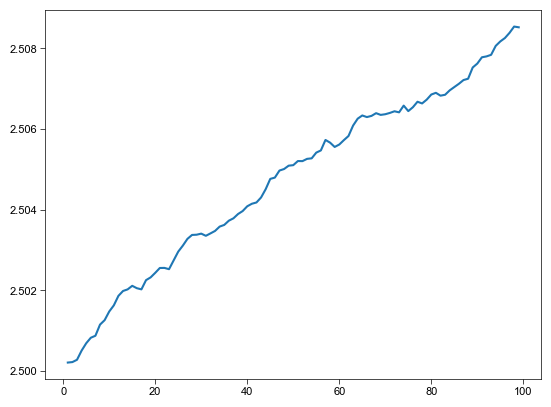

In [162]:
plt.plot(np.arange(1,100), np.mean(sol_2['w_mean'][:,1:],axis=0))

<BarContainer object of 120 artists>

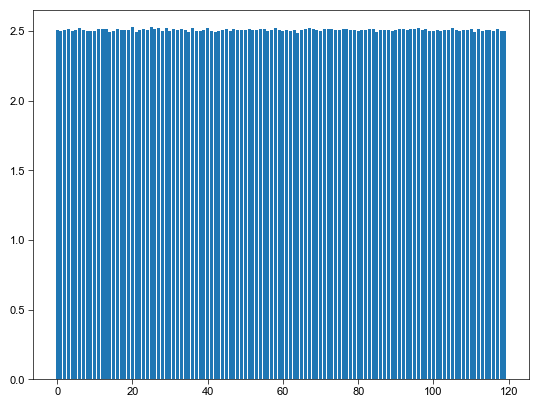

In [142]:
plt.bar(np.arange(N_PFs), np.mean(sol_2['w_final'],axis=0))

In [143]:
hist_end = np.sum(hist_history_PF[:,:,:,-1], axis=0)

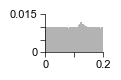

In [152]:


plt.figure(figsize=(0.75,0.5))

i = 0

plt.bar(hist_edges[:-1], hist_end[i,:]/np.sum(hist_end[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.015])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.015, 4))
ax.set_yticklabels([0,'','',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

plt.savefig('figures/structured-hist-end-0.pdf')

# Start with untuned rule, metaplasticity

In [14]:
# np.save('files/integrated simulation/structured meta/hist_history.npy', sol_untuned['hist_history_PF'])
vs_old = np.load('files/integrated simulation/structured meta/vs.npy')

In [175]:
v_0 = np.zeros((N_PFs, N_states))
v_0[:,0] = 1
# v_0 = np.copy(vs_old[-1,])

sol_untuned = simulateLearningModeOKR(200, 1000, np.arange(N_PFs)*w_max/2, v_0, PF_samples=[38, 54,80], history_samples=100, metaplasticity=True)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:03<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [185]:
np.save('files/integrated simulation/structured meta/hist_history.npy', sol_untuned['hist_history_PF'])
np.save('files/integrated simulation/structured meta/vs.npy', sol_untuned['vs'])

In [176]:
hist_end = np.sum(sol_untuned['hist_history_PF'][:,:,:,-1], axis=0)

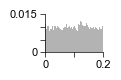

In [180]:
plt.figure(figsize=(0.75,0.5))

i = 3

plt.bar(hist_edges[:-1], hist_end[i,:]/np.sum(hist_end[i,:]), hist_edges[1],align='edge', facecolor=(0.7,)*3)
plt.xlim([0, 0.2])
plt.ylim([0, 0.015])

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_yticks(np.linspace(0, 0.015, 4))
ax.set_yticklabels([0,'','',0.015])
ax.set_xticks([0, 0.1,0.2])
ax.set_xticklabels([0,'',0.2])

plt.savefig('figures/structured-hist-meta-3.pdf')

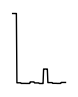

In [183]:
plt.figure(figsize=(0.75,1))

i = 2
plt.plot(t_states, sol_untuned['vs'][-1,i,:,-1]@states.T, c='k', lw=1)
plt.axis('off')
plt.savefig('figures/structured-eligibility-end-{0:d}.pdf'.format(i+1))

# Working space

In [62]:
avg_sensitivity_to_pc = 0.01
pc_eye_sensitivity = 0.1

In [45]:
target_on = True

In [105]:
inds_random = np.arange(N_PFs)
history_samples = 20
N_trials = 1000
N_repetitions = 1

dw_d = np.zeros((N_repetitions, N_PFs, N_trials))
dw_p = np.zeros((N_repetitions, N_PFs, N_trials))

dw_d_avg = np.zeros((N_repetitions,N_PFs, N_trials))
dw_p_avg = np.zeros((N_repetitions, N_PFs, N_trials))

eligibility_windows = v_0@states.T

if history_samples == 0:
        history_samples = N_repetitions
sample_interval = int(np.floor(N_trials/history_samples))

eye_history = np.zeros((N_repetitions, len(t), history_samples))
eye_history_no_noise = np.zeros((N_repetitions, len(t), history_samples))

hist_history_PF = np.zeros((N_repetitions, len(PF_samples) + 1, N_bins,history_samples))
state_counts = np.zeros((N_repetitions, len(PF_samples)+1, N_states))

#     if metaplasticity and len(PF_samples) > 0:
#         vs = np.zeros((N_repetitions, len(PF_samples), N_states, history_samples))

w_final = np.zeros((N_repetitions, N_PFs))
w_avg_final = np.zeros((N_repetitions, N_PFs))

cf_prob_avg = np.zeros((N_repetitions, len(t), history_samples)) # Calculate CF probability 

if len(PF_samples) > 0:
    w_test = np.zeros((N_repetitions, len(PF_samples), history_samples))
w_mean = np.zeros((N_repetitions, history_samples))

for rep in tqdm.notebook.trange(N_repetitions):
    w = np.ones(N_PFs)*w_max/2
    w_avg = np.ones(N_PFs)*w_max/2
    n_to_divide = 0
    sample_count = 1

    # hist_history_rep = np.zeros((len(PF_samples)+1, N_bins))
    hist_history_rep = np.zeros((len(PF_samples)+1, N_bins))
    cf_prob_rep = np.zeros(len(t))

    for tt in tqdm.notebook.trange(N_trials, leave=False):  
        if shuffle:
            rng.shuffle(inds_random)

        # Generate PF spikes for sample PC
        pf_spikes = rng.random(size=pf_spike_rates.shape) < pf_spike_rates[inds_random,:]*dt
        pf_spikes_weighted = w@pf_spikes
        pc_current_exc = dt*conv_circ(pf_spikes_weighted/dt, exc_current_kernel)

        # Generate PC firing rate for rest of population
#             pc_current_exc_avg_bef = w_avg[inds_random]@(pf_spike_rates)
#             pc_current_exc_avg_no_noise = dt*conv_circ(pc_current_exc_avg_bef, exc_current_kernel)

#             pc_current_exc_avg = dt*conv_circ(pc_current_exc_avg_bef, exc_current_kernel)
        pc_current_exc_avg_no_noise = dt*conv_circ(w[inds_random]@(pf_spike_rates), exc_current_kernel)


        # Subtract MLI current
        # mli_current_same = dt*conv_circ(np.sum(pf_spikes/dt, axis=0), inh_current_kernel)

        pc_current = pc_current_exc - w_mli*mli_current
        # pc_current_avg = pc_current_exc_avg - w_mli*mli_current
        pc_current_avg_no_noise = pc_current_exc_avg_no_noise - w_mli*mli_current

        random_target = pc_eye_sensitivity*conv_circ(0.5*rng.standard_normal(len(t)), exc_current_kernel)

        # Generate eye movement
#             eye = (pc_eye_sensitivity*(pc_current_avg*(1-avg_sensitivity_to_pc) + pc_current*avg_sensitivity_to_pc)
#                    ) + direct_pathway
        eye =  pc_eye_sensitivity*pc_current

        # Calculate retinal slip
        # Assume we are combining N PCs (s.t. avg_sensitivity_to_pc = 1/N)
        # Let the random_target represent the effect of the remaining N-1
        retinal_slip = target_on*random_target*np.sqrt(avg_sensitivity_to_pc*(1-avg_sensitivity_to_pc)) - eye*avg_sensitivity_to_pc
        # retinal_slip = target_on*random_target - eye
        
        # Calculate CF probability (here, contraversive RS)
        cf_prob = retinal_slip_f(retinal_slip)
        # Delay the CF probability distribution

        # Rescale so that the average rate over the block is ~1 Hz
        if np.sum(cf_prob) > 0:
            cf_prob /= np.sum(cf_prob)
            cf_prob *= avg_cf_rate*T
        # cf_prob_shifted = np.roll(cf_prob, int(delay/dt))
        cf_prob_shifted = conv_circ(cf_prob, delay_distr)

        if tt > 0 and tt % sample_interval == 0:
            eye_history[rep,:,sample_count] = pc_eye_sensitivity*pc_current
            eye_history_no_noise[rep, :,sample_count] = pc_eye_sensitivity*pc_current_avg_no_noise

            hist_history_PF[rep, :, :, sample_count] += hist_history_rep
            cf_prob_avg[rep, :, sample_count] += cf_prob_rep/n_to_divide
            w_mean[rep, sample_count] = np.mean(w)
            if len(PF_samples) > 0:
                w_test[rep, :, sample_count] = np.copy(w[PF_samples])
#                 if metaplasticity:
#                     vs[rep,:, :, sample_count] = np.copy(v[PF_samples,:])
            sample_count += 1

        ## Choose CF spikes
        if np.sum(cf_prob) > 0:
            # cf_prob_cdf = np.cumsum(cf_prob)
            # cf_spike_time = np.interp(rng.random(), cf_prob_cdf, t)+0.12
            cf_prob_rep += cf_prob_shifted
            n_to_divide += 1
            cf_prob_cdf = np.cumsum(cf_prob_shifted)
            cf_spike_time = np.interp(rng.random(), cf_prob_cdf, t)

        ## Do plasticity
        for j in range(N_PFs):
            eligibility_window = eligibility_windows[j,:]
            ## Firing rates

            pf_rate = pf_spike_rates[inds_random[j],:]
            if np.sum(cf_prob_shifted) > 0:
                pf_eligibility = dt*conv_circ(pf_rate,eligibility_window)
                dw_avg_d = np.sum(pf_eligibility*cf_prob_shifted)
            else:
                dw_avg_d = 0
            dw_avg_p = np.sum(pf_rate*dt)

            w_avg[j] += -dw_ltd_avg*dw_avg_d + dw_ltp_avg*dw_avg_p
            dw_d_avg[rep, j,tt] = dw_avg_d
            dw_p_avg[rep, j,tt] = dw_avg_p

            for s in np.where(pf_spikes[j,:])[0]:
                dw_p[rep, j,tt] += 1
                w[j] += dw_ltp

                if np.sum(cf_prob) > 0:
                    spike_time_1 = cf_spike_time - t[s]
                    # use circular assumption for simplicity
#                     spike_time_2 = spike_time_1 - T_max_full + T_min_full
                    spike_time_2 = spike_time_1 + T_max_full - T_min_full

                    if 0 <= spike_time_1 <= 0.2 or 0<= spike_time_2 <= 0.2:
                        if 0<=spike_time_1<=0.2:
                            cf_spike_ind = int(np.floor((spike_time_1)/dt))
                            active_timer = np.digitize(spike_time_1, edges*dt)-1
                            hist_bin = np.digitize(spike_time_1, hist_edges)-1
                        else:
                            cf_spike_ind = int(np.floor((spike_time_2)/dt))
                            active_timer = np.digitize(spike_time_2, edges*dt)-1
                            hist_bin = np.digitize(spike_time_2, hist_edges)-1

                        state_counts[rep, 0, active_timer] += 1
                        hist_history_rep[0, hist_bin] += 1
                        for p in range(len(PF_samples)):
                            if j == PF_samples[p]:
                                state_counts[rep, p+1, active_timer] += 1
                                hist_history_rep[p+1, hist_bin] += 1

                        ## Plasticity
                        dw = eligibility_window[cf_spike_ind]
                        dw_d[rep, j,tt] += dw
                        w[j] -= dw*dw_ltd

            if w_avg[j] < w_min: w_avg[j] = w_min
            elif w_avg[j] > w_max: w_avg[j] = w_max
            w_avg[j] += decay_rate*(w_max/2 - w_avg[j])


            if w[j] < w_min: w[j] = w_min
            elif w[j] > w_max: w[j] = w_max
            w[j] += decay_rate*(w_max/2 - w[j])
    w_final[rep,:] = np.copy(w)
    w_avg_final[rep,:] = np.copy(w_avg)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

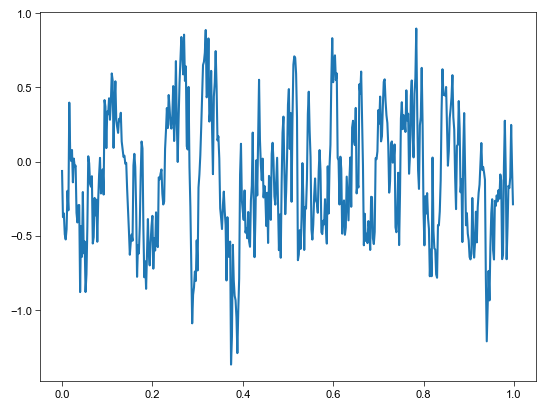

In [106]:
plt.plot(t, retinal_slip)

In [107]:
np.mean(np.sum(dw_d, axis=1)/np.sum(dw_p, axis=1),axis=1)

array([0.02041229])

In [108]:
np.mean(np.sum(-dw_d + dw_p*0.019495, axis=1), axis=1)

array([-0.04772205])

In [109]:
np.mean(np.mean(dw_d_avg, axis=1)/np.mean(dw_p_avg, axis=1),axis=1)

array([0.016])

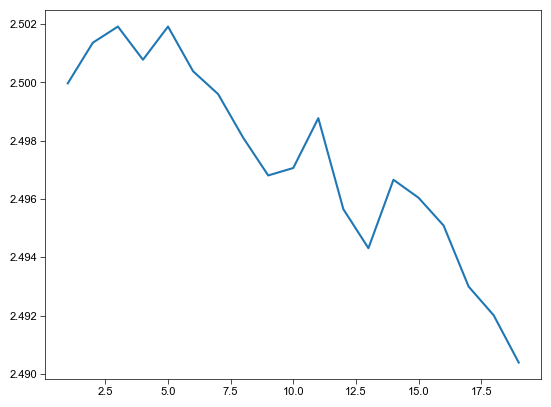

In [110]:
plt.plot(np.arange(1,history_samples), w_mean[0,1:])